## Course QA Modelling

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV, LeaveOneOut
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, classification_report

In [2]:
# import hpi data
hpi_feature_path = 'C:/Users/ywa/Documents/Data/Predictive modelling/2024-12-31_OverallCourseSummaryReport_2024-12-31_training.xlsx'

hpi_df = pd.read_excel(hpi_feature_path)
hpi_df.columns

feature_list = ['title', 'language', 'published_sections', 'enrollments_total', 'records_of_achievement', 'start_date', 'display_start_date']

hpi_feature = hpi_df.loc[: , feature_list]

hpi_feature = hpi_feature.dropna(subset = ['enrollments_total'])

In [48]:
#hpi_feature.to_excel('C:/Users/ywa/Documents/Data/Predictive modelling/hpi_features.xlsx')

In [3]:
# merge edited table and the one with date
table1_path = 'C:/Users/ywa/Documents/Data/Predictive modelling/hpi_features.xlsx'
table2_path = 'C:/Users/ywa/Documents/Data/Predictive modelling/hpi_features_edited.xlsx'

hpi_edited = pd.read_excel(table2_path)
hpi_non = pd.read_excel(table1_path)

hpi_features = hpi_edited.merge(hpi_non, on = 'Unnamed: 0', how = 'left')
hpi_features = hpi_features.drop(['title_y', 'language_y', 'published_sections_y', 'enrollments_total_y', 'records_of_achievement_y'], axis = 1)

#hpi_features.head()


In [57]:
#hpi_features.to_excel('C:/Users/ywa/Documents/Data/Predictive modelling/hpi_features_final.xlsx')

* The base table is ready, the KAMs needs to provide infos on the course review suggestion and release dates.

In [4]:
# Import post-survey scores and merge with the base table
post_path = 'C:/Users/ywa/Documents/Data/Predictive modelling/survey_features.xlsx'
base_path = 'C:/Users/ywa/Documents/Data/Predictive modelling/hpi_features_final.xlsx'

post = pd.read_excel(post_path)
base = pd.read_excel(base_path)

features = base.merge(post, left_on = ['title'], right_on = 'course', how = 'outer')


In [5]:
features = features.drop(['index', 'Unnamed: 0_x', 'Unnamed: 0_y'], axis = 1)
#features

In [23]:
#features
#features.to_excel('C:/Users/ywa/Documents/Data/Predictive modelling/training_feature.xlsx', index = False)

In [6]:
# load feature DataFrame
training_df = pd.read_excel('C:/Users/ywa/Documents/Data/Predictive modelling/training_feature.xlsx', sheet_name = 'Sheet1')

training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   title                        74 non-null     object        
 1   language                     74 non-null     object        
 2   published_sections           74 non-null     int64         
 3   enrollments_total            74 non-null     int64         
 4   records_of_achievement       74 non-null     int64         
 5   category                     74 non-null     object        
 6   Date go-live                 74 non-null     datetime64[ns]
 7   Approx. date last enrolment  74 non-null     datetime64[ns]
 8   Mean_Q1                      68 non-null     float64       
 9   Mean_Q4                      68 non-null     float64       
 10  Sum_Q1                       70 non-null     float64       
 11  Sum_Q4                       70 non-null     fl

In [7]:
# deal with missing values
training_df.isna().sum()

title                          0
language                       0
published_sections             0
enrollments_total              0
records_of_achievement         0
category                       0
Date go-live                   0
Approx. date last enrolment    0
Mean_Q1                        6
Mean_Q4                        6
Sum_Q1                         4
Sum_Q4                         4
label                          0
dtype: int64

In [8]:
# missing mean of the courses will depend on the course category and the course 
# group by category and course label
interpolation = training_df.groupby(['category', 'label'])['Mean_Q1', 'Mean_Q4'].mean()
interpolation

# isolate the missing value rows
missing = training_df[training_df['Mean_Q1'].isna()]
missing

C:\Users\ywa\AppData\Local\Temp\ipykernel_4480\2710681810.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  interpolation = training_df.groupby(['category', 'label'])['Mean_Q1', 'Mean_Q4'].mean()


,title,language,published_sections,enrollments_total,records_of_achievement,category,Date go-live,Approx. date last enrolment,Mean_Q1,Mean_Q4,Sum_Q1,Sum_Q4,label
11,"""Künstliche Intelligenz in der Gesundheitsvers...",de,18,689,84,Med,2023-02-13,2024-11-29,NaN,NaN,NaN,NaN,No update
13,"""Lernfabrik 4.0 - Steuerung , Monitoring und N...",de,9,88,0,Industry40,2022-12-12,2023-10-02,NaN,NaN,0.0,0.0,Archived
19,"""Dr. med. KI - Basler Modul""",de,9,234,206,Med,2022-10-03,2024-07-11,NaN,NaN,NaN,NaN,No update
24,"""Deep Learning mit Tensorflow, Keras und Tenso...",de,12,766,85,ML,2022-09-01,2024-11-05,NaN,NaN,NaN,NaN,Update
27,"""Foundations of Artificial Intelligence VI""",en,7,205,19,Studieren,2022-07-15,2024-12-03,NaN,NaN,0.0,0.0,No update
39,"""Applied Edge AI: Deep Learning Outside of the...",en,10,540,34,ML,2022-01-12,2022-08-25,NaN,NaN,NaN,NaN,Archived


In [10]:
# using interploated mean to replace missing values from each category. 
na_cols = ['Mean_Q1', 'Mean_Q4']

for col in na_cols:
    missing.loc[:, col] = missing.apply(
         lambda row: interpolation.loc[(row['category'], row['label']), col] 
        if (row['category'], row['label']) in interpolation.index and pd.isna(row[col]) 
        else row[col],
        axis=1
    )

missing

C:\Users\ywa\AppData\Local\Temp\ipykernel_4480\2041415288.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing.loc[:, col] = missing.apply(
C:\Users\ywa\AppData\Local\Temp\ipykernel_4480\2041415288.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing.loc[:, col] = missing.apply(


,title,language,published_sections,enrollments_total,records_of_achievement,category,Date go-live,Approx. date last enrolment,Mean_Q1,Mean_Q4,Sum_Q1,Sum_Q4,label
11,"""Künstliche Intelligenz in der Gesundheitsvers...",de,18,689,84,Med,2023-02-13,2024-11-29,3.193256,2.816321,NaN,NaN,No update
13,"""Lernfabrik 4.0 - Steuerung , Monitoring und N...",de,9,88,0,Industry40,2022-12-12,2023-10-02,3.045455,2.559596,0.0,0.0,Archived
19,"""Dr. med. KI - Basler Modul""",de,9,234,206,Med,2022-10-03,2024-07-11,3.193256,2.816321,NaN,NaN,No update
24,"""Deep Learning mit Tensorflow, Keras und Tenso...",de,12,766,85,ML,2022-09-01,2024-11-05,3.232989,2.755195,NaN,NaN,Update
27,"""Foundations of Artificial Intelligence VI""",en,7,205,19,Studieren,2022-07-15,2024-12-03,2.880256,2.827236,0.0,0.0,No update
39,"""Applied Edge AI: Deep Learning Outside of the...",en,10,540,34,ML,2022-01-12,2022-08-25,3.555556,2.851852,NaN,NaN,Archived


## investigate how to interpolate the missing sum values

<Axes: xlabel='enrollments_total', ylabel='Sum_Q1'>

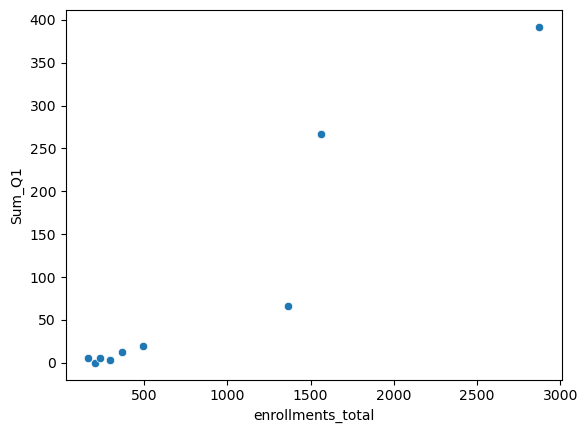

In [11]:
# check out the correlation between sum values and enrollment
# cat_studieren
cat_studieren = training_df[training_df['category'] == 'Studieren']

sns.scatterplot(data = cat_studieren, x = 'enrollments_total', y = 'Sum_Q1')


<Axes: xlabel='enrollments_total', ylabel='Sum_Q1'>

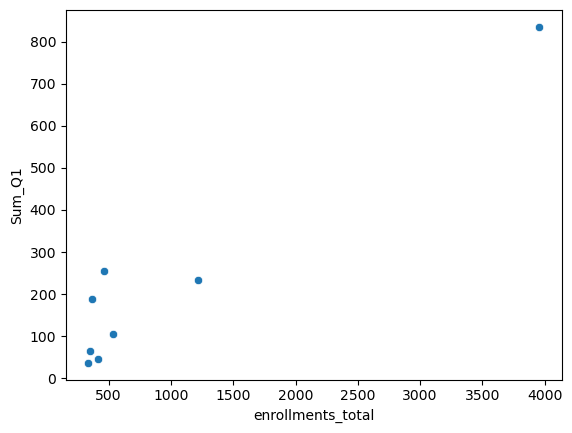

In [12]:
# cat_med
cat_med = training_df[training_df['category'] == 'Med']
sns.scatterplot(data = cat_med, x = 'enrollments_total', y = 'Sum_Q1')

<Axes: xlabel='enrollments_total', ylabel='Sum_Q1'>

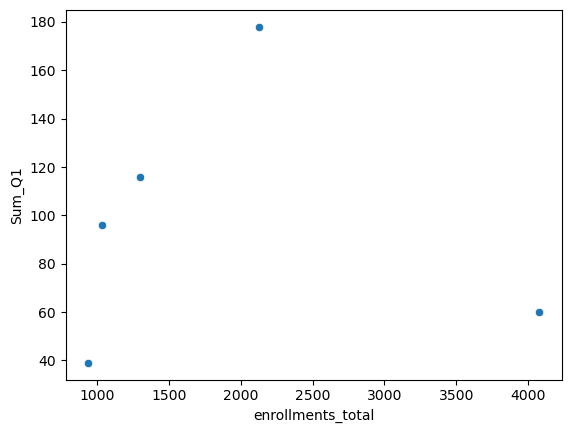

In [189]:
# cat_ML
cat_ml = training_df[training_df['category'] == 'ML']
sns.scatterplot(data = cat_ml, x = 'enrollments_total', y = 'Sum_Q1')

<Axes: xlabel='enrollments_total', ylabel='Sum_Q1'>

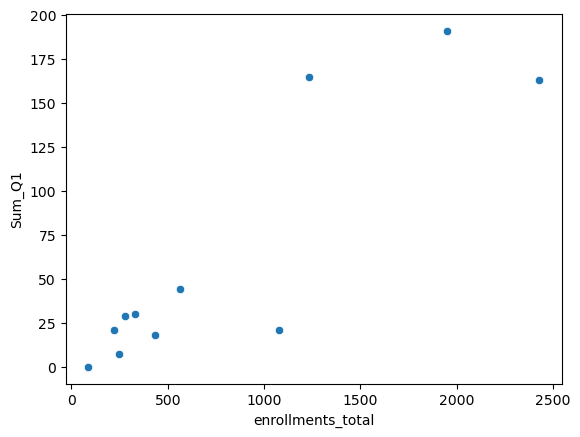

In [190]:
# cat_Industry40
cat_industry = training_df[training_df['category'] == 'Industry40']
sns.scatterplot(data = cat_industry, x = 'enrollments_total', y = 'Sum_Q1')


In [191]:
# The interpolation of mean value doesn't make sense to genralise the ratio for the sum calculation

#missing['Sum_Q1'] = missing['Mean_Q1'] * missing['enrollments_total'] * 0.05
#missing['Sum_Q4'] = missing['Mean_Q4'] * missing['enrollments_total'] * 0.05

print(len(training_df))
training_df = pd.concat([training_df, missing], axis = 0)
print(len(training_df))
training_df = training_df.drop_duplicates(subset = ['title', 'enrollments_total'], keep = 'last')
print(len(training_df))

74
80
74


In [192]:
# datatype check
training_df['language'] = training_df['language'].astype('category')
training_df['category'] = training_df['category'].astype('category')
training_df['label'] = training_df['label'].astype('category')

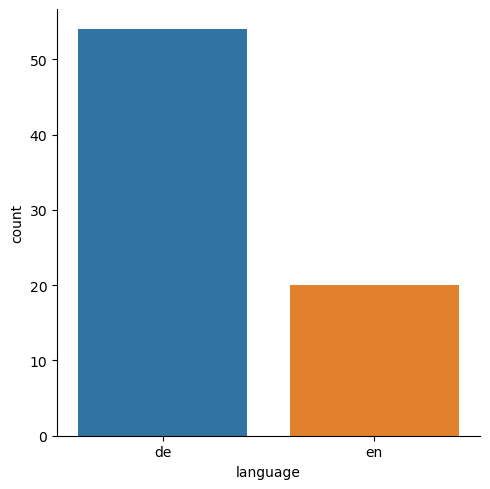

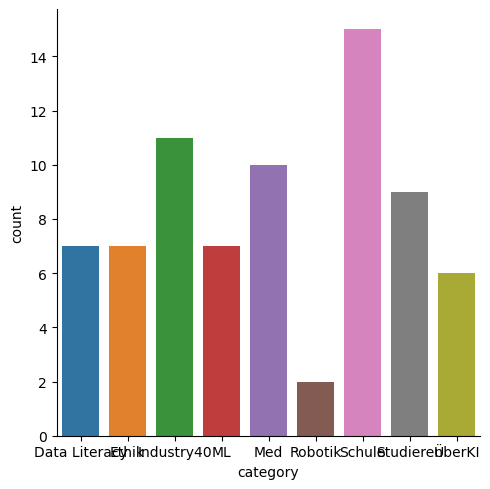

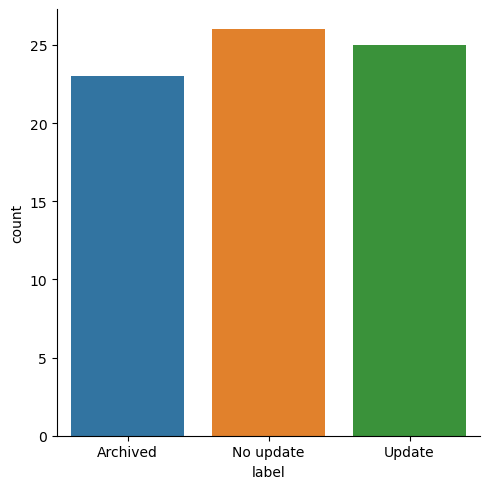

In [193]:
# investigate the course categories
sns.catplot(data = training_df, x = 'language', kind = 'count' )
sns.catplot(data = training_df, x = 'category', kind = 'count')
sns.catplot(data = training_df, x = 'label', kind = 'count')

<Axes: xlabel='published_sections', ylabel='Count'>

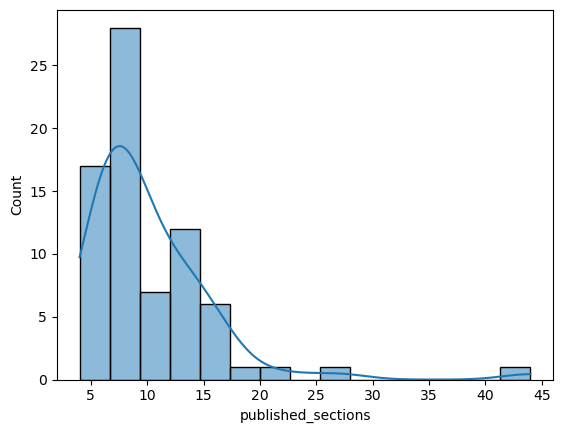

In [194]:
# check the distribution of numeric values
sns.histplot(data = training_df, x = 'published_sections', kde = True)


<Axes: xlabel='enrollments_total', ylabel='Count'>

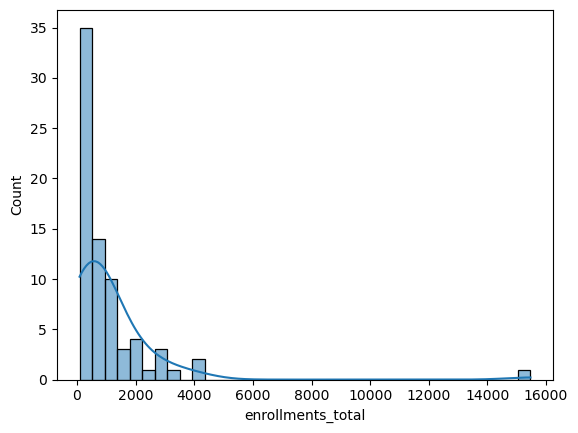

In [195]:
sns.histplot(data = training_df, x = 'enrollments_total', kde = True) 


<Axes: xlabel='records_of_achievement', ylabel='Count'>

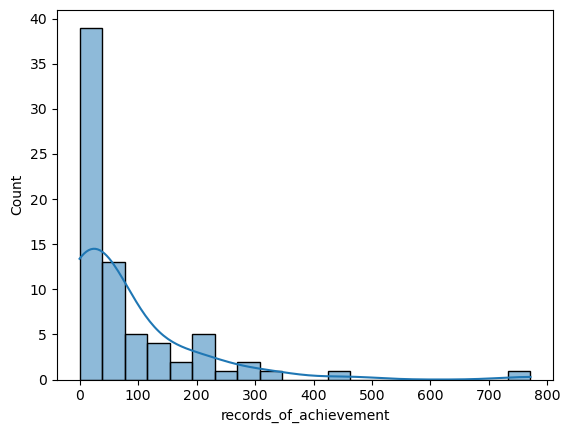

In [196]:
sns.histplot(data = training_df, x = 'records_of_achievement', kde = True)


<Axes: ylabel='Frequency'>

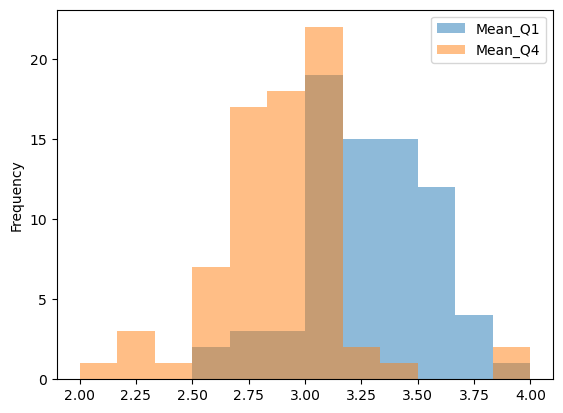

In [207]:
#sns.histplot(data = training_df, x = 'Mean_Q1', kde = True)
#sns.histplot(data = training_df, x = 'Mean_Q4', kde = True)
mean_df = training_df[['Mean_Q1', 'Mean_Q4']]
#mean_df
mean_df.plot.hist(bins = 12, alpha = 0.5)

<Axes: xlabel='records_of_achievement'>

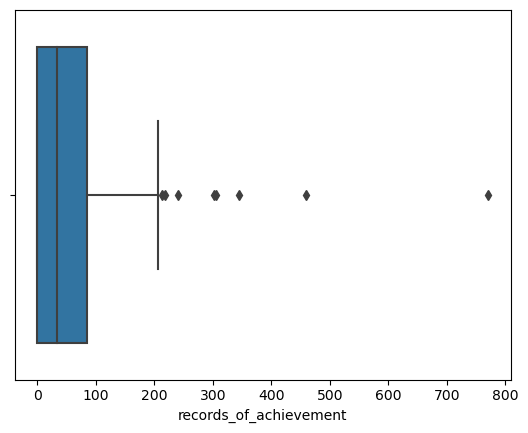

In [155]:
# check outliers
#sns.boxplot(data = training_df, x = 'published_sections')
#sns.boxplot(data = training_df, x = 'enrollments_total')
#sns.boxplot(data = training_df, x = 'records_of_achievement')

### The outliers in this case are "meaningful", therefore they should not be excluded from the dataset
--> here starts feature engineering

In [208]:
# feature engineering

# datetime to duration
training_df['duration'] = training_df['Approx. date last enrolment'] - training_df['Date go-live']
training_df['duration'] = training_df['duration'].astype('str')

training_df['duration'] = training_df['duration'].str.replace(' days', '')
training_df['duration'] = training_df['duration'].astype('int')
training_df.head()


,title,language,published_sections,enrollments_total,records_of_achievement,category,Date go-live,Approx. date last enrolment,Mean_Q1,Mean_Q4,Sum_Q1,Sum_Q4,label,duration
0,"""Learn2Trust - Vertrauen durch Verständnis von...",de,6,338,151,Med,2023-05-26,2024-12-03,3.083333,2.833333,37.0,34.0,Archived,557
1,"""Practising Artificial Intelligence""",en,7,294,20,Studieren,2023-09-01,2024-10-16,3.000000,3.000000,3.0,3.0,Archived,411
2,"""KI und Ethik""",de,44,131,0,Ethik,2020-06-26,2022-07-19,4.000000,4.000000,8.0,8.0,Archived,753
3,"""Learning Analytics für Lehrkräfte""",de,13,767,73,Schule,2023-09-12,2024-07-31,3.000000,2.480000,75.0,62.0,No update,323
4,"""Bildungsdatenkompetenz""",de,6,182,28,Schule,2023-09-01,2024-11-29,3.000000,2.571429,21.0,18.0,Archived,455


In [209]:
# one-hot encoding...

# the title column should not be encoded
training_df['id'] = np.arange(len(training_df))
training_for_encode = training_df.drop(['title', 'Date go-live', 'Approx. date last enrolment', 'Sum_Q1', 'Sum_Q4', 'label'], axis = 1)

one_hot_training = pd.get_dummies(training_for_encode)
one_hot_training.head()

,published_sections,enrollments_total,records_of_achievement,Mean_Q1,Mean_Q4,duration,id,language_de,language_en,category_Data Literacy,category_Ethik,category_Industry40,category_ML,category_Med,category_Robotik,category_Schule,category_Studieren,category_ÜberKI
0,6,338,151,3.083333,2.833333,557,0,1,0,0,0,0,0,1,0,0,0,0
1,7,294,20,3.000000,3.000000,411,1,0,1,0,0,0,0,0,0,0,1,0
2,44,131,0,4.000000,4.000000,753,2,1,0,0,1,0,0,0,0,0,0,0
3,13,767,73,3.000000,2.480000,323,3,1,0,0,0,0,0,0,0,1,0,0
4,6,182,28,3.000000,2.571429,455,4,1,0,0,0,0,0,0,0,1,0,0


In [243]:
# selecting features
X = one_hot_training.drop(['id', 'language_en'], axis = 1)
y = training_df['label']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

#print(training_df['label'].tail(10))
#print(y)


In [211]:
# check feature size
print(X.shape)
print(y.shape)

(74, 16)
(74,)


In [214]:
# initialise estimator
tree = DecisionTreeClassifier()
knn = KNeighborsClassifier()

### The two methods towards the limited datasets: a) Train/Validataion/Test data split b) k-fold cv
### a) Split data with stratification

In [224]:
# split training and (validation + test) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.4, stratify = y, random_state = 12)

# split validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, stratify = y_temp, random_state = 12)


In [230]:
# using grid search to select a set of hyperparams
param_tree = {'criterion' : ['gini', 'entropy', 'log_loss'], 'splitter' : ['best', 'random'], 'max_depth' : [4, 5, 6], 'min_samples_split' : [4, 5], 'random_state' : [12]}

param_knn = {'n_neighbors' : [3, 4, 5, 6], 'weights' : ['uniform', 'distance'], 'leaf_size' : [25, 30, 35, 40], 'p' : [1, 2]}

search_tree = GridSearchCV(tree, param_tree, cv = 5)
search_tree.fit(X_train, y_train)
print(search_tree.best_params_)

search_knn = GridSearchCV(knn, param_knn, cv = 5)
search_knn.fit(X_train, y_train)
print(search_knn.best_params_)


{'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 4, 'random_state': 12, 'splitter': 'random'}
{'leaf_size': 25, 'n_neighbors': 4, 'p': 1, 'weights': 'distance'}


In [232]:
# fit and evaluate models with the best hyper parameters
# initalise the "best" estimators
best_tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = 6, min_samples_split = 4, random_state = 12, splitter = 'random')
best_knn = KNeighborsClassifier(leaf_size = 25, n_neighbors = 4, p = 1, weights = 'distance')

In [233]:
# fit the best models
best_tree.fit(X_train, y_train)
best_knn.fit(X_train, y_train)

# validate models by prediction and calculate scores
y_pred_best_tree = best_tree.predict(X_val)
y_pred_best_knn = best_knn.predict(X_val)


For the class labeling: Archived = 0 No update = 1 Update = 2

In [255]:
# calculate scores of tree model
print(confusion_matrix(y_val, y_pred_best_tree))
print(accuracy_score(y_val, y_pred_best_tree))
print(f1_score(y_val, y_pred_best_tree, average = 'weighted'))
print(recall_score(y_val, y_pred_best_tree, average = 'weighted'))
print(precision_score(y_val, y_pred_best_tree, average = 'weighted'))
print(classification_report(y_val, y_pred_best_tree))

[[1 1 3]
 [0 4 1]
 [1 1 3]]
0.5333333333333333
0.5043290043290043
0.5333333333333333
0.5317460317460317
              precision    recall  f1-score   support

           0       0.50      0.20      0.29         5
           1       0.67      0.80      0.73         5
           2       0.43      0.60      0.50         5

    accuracy                           0.53        15
   macro avg       0.53      0.53      0.50        15
weighted avg       0.53      0.53      0.50        15



In [256]:
# calculate scores of knn model
print(confusion_matrix(y_val, y_pred_best_knn))
print(accuracy_score(y_val, y_pred_best_knn))
print(f1_score(y_val, y_pred_best_knn, average = 'weighted'))
print(recall_score(y_val, y_pred_best_knn, average = 'weighted'))
print(precision_score(y_val, y_pred_best_knn, average = 'weighted'))
print(classification_report(y_val, y_pred_best_knn))

[[4 0 1]
 [2 1 2]
 [1 2 2]]
0.4666666666666667
0.43888888888888894
0.4666666666666667
0.43492063492063493
              precision    recall  f1-score   support

           0       0.57      0.80      0.67         5
           1       0.33      0.20      0.25         5
           2       0.40      0.40      0.40         5

    accuracy                           0.47        15
   macro avg       0.43      0.47      0.44        15
weighted avg       0.43      0.47      0.44        15



## On average, the tree model performes better than the knn model. However, only half of the cases are correctly predicted.
--> second round of grid search and fine tune the hyper parameter

In [260]:
tune_tree_param = {'criterion' : ['gini', 'entropy', 'log_loss'], 'splitter' : ['best', 'random'], 'max_depth' : [3, 4, 5, 6, 7], 'min_samples_split' : [2, 3, 4, 5], 'random_state' : [12]}

tune_knn_param = {'n_neighbors' : [3, 4, 5], 'weights' : ['uniform', 'distance'], 'leaf_size' : [10, 15, 20, 25, 30], 'p' : [ 1, 1.25, 1.5, 1.75, 2, 2.25, 2.75, 3]}


search_tree_tune = GridSearchCV(tree, tune_tree_param, cv = 5)
search_tree_tune.fit(X_train, y_train)
print(search_tree_tune.best_params_)

search_knn_tune = GridSearchCV(knn, tune_knn_param, cv = 5)
search_knn_tune.fit(X_train, y_train)
print(search_knn_tune.best_params_)

# only knn model was improved with another set of parameters

{'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 4, 'random_state': 12, 'splitter': 'random'}
{'leaf_size': 10, 'n_neighbors': 3, 'p': 2.25, 'weights': 'distance'}


In [262]:
search_tune_knn = KNeighborsClassifier(leaf_size = 10, n_neighbors = 3, p = 2.25, weights = 'distance')
search_tune_knn.fit(X_train, y_train)
y_pred_search_tune_knn = search_tune_knn.predict(X_val)

In [263]:
print(confusion_matrix(y_val, y_pred_search_tune_knn))
print(accuracy_score(y_val, y_pred_search_tune_knn))
print(f1_score(y_val, y_pred_search_tune_knn, average = 'weighted'))
print(recall_score(y_val, y_pred_search_tune_knn, average = 'weighted'))
print(precision_score(y_val, y_pred_search_tune_knn, average = 'weighted'))
print(classification_report(y_val, y_pred_search_tune_knn))

[[4 1 0]
 [2 1 2]
 [1 2 2]]
0.4666666666666667
0.4444444444444445
0.4666666666666667
0.44047619047619047
              precision    recall  f1-score   support

           0       0.57      0.80      0.67         5
           1       0.25      0.20      0.22         5
           2       0.50      0.40      0.44         5

    accuracy                           0.47        15
   macro avg       0.44      0.47      0.44        15
weighted avg       0.44      0.47      0.44        15



#### the knn is not significantly imporved, try out the random search
--> also try the random searh for a better result

In [43]:
tree_random_param = {'criterion' : ['gini', 'entropy', 'log_loss'], 'splitter' : ['best', 'random'], 'max_depth' : np.arange(10), 'min_samples_split' : np.arange(2, 5, 1), 'min_samples_leaf' : np.arange(1, 4, 1), 'max_features' : [None, 'sqrt', 'log2'], 'random_state' : [12]}
knn_random_param = {'n_neighbors' : np.arange(2, 10, 1), 'weights' : ['uniform', 'distance'], 'p' : np.arange(1, 5, 0.25), 'leaf_size': np.arange(10, 30, 5)}

random_tree = RandomizedSearchCV(tree, param_distributions = tree_random_param, n_iter=15, random_state = 12)
random_tree.fit(X_train, y_train)
print(random_tree.best_params_)


random_knn = RandomizedSearchCV(knn, param_distributions = knn_random_param, n_iter=15, random_state = 12)
random_knn.fit(X_train, y_train)
print(random_knn.best_params_)


C:\Users\ywa\AppData\Local\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ywa\AppData\Local\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ywa\AppData\Local\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 889, in fit
    super().fit(
  File "C:\Users\ywa\AppData\Local\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 177, in fit
    self._validate_params()
  File "C:\Users\ywa\AppDat

{'splitter': 'best', 'random_state': 12, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 7, 'criterion': 'gini'}
{'weights': 'distance', 'p': 1.25, 'n_neighbors': 2, 'leaf_size': 10}


In [48]:
# initialise the randomCV model
random_best_tree = DecisionTreeClassifier(criterion = 'gini', max_depth = 7, min_samples_split = 2, random_state = 12, splitter = 'best', min_samples_leaf = 2, max_features = None)

random_best_knn = KNeighborsClassifier(leaf_size = 10, n_neighbors = 2, p = 1.25, weights = 'distance')

In [49]:
# fit and predict on valuation set
random_best_tree.fit(X_train, y_train)
random_best_knn.fit(X_train, y_train)

y_pred_random_tree = random_best_tree.predict(X_val)
y_pred_random_knn = random_best_knn.predict(X_val)


In [50]:
# evaluation of the randomCV models
# decision tree
print(confusion_matrix(y_val, y_pred_random_tree))
print(accuracy_score(y_val, y_pred_random_tree))
print(f1_score(y_val, y_pred_random_tree, average = 'weighted'))
print(recall_score(y_val, y_pred_random_tree, average = 'weighted'))
print(precision_score(y_val, y_pred_random_tree, average = 'weighted'))
print(classification_report(y_val, y_pred_random_tree))

[[3 1 1]
 [3 2 0]
 [0 2 3]]
0.5333333333333333
0.5373737373737374
0.5333333333333333
0.55
              precision    recall  f1-score   support

           0       0.50      0.60      0.55         5
           1       0.40      0.40      0.40         5
           2       0.75      0.60      0.67         5

    accuracy                           0.53        15
   macro avg       0.55      0.53      0.54        15
weighted avg       0.55      0.53      0.54        15



In [51]:
# knn
print(confusion_matrix(y_val, y_pred_random_knn))
print(accuracy_score(y_val, y_pred_random_knn))
print(f1_score(y_val, y_pred_random_knn, average = 'weighted'))
print(recall_score(y_val, y_pred_random_knn, average = 'weighted'))
print(precision_score(y_val, y_pred_random_knn, average = 'weighted'))
print(classification_report(y_val, y_pred_random_knn))

[[4 1 0]
 [2 0 3]
 [1 2 2]]
0.4
0.35555555555555557
0.4
0.32380952380952377
              precision    recall  f1-score   support

           0       0.57      0.80      0.67         5
           1       0.00      0.00      0.00         5
           2       0.40      0.40      0.40         5

    accuracy                           0.40        15
   macro avg       0.32      0.40      0.36        15
weighted avg       0.32      0.40      0.36        15



#### The random tree performs better than the grid search tree. However, the scores are still low...
--> decision tree classifier outerperforms the knn classifier
* Neverthe less, evaluate the test set with the best model.

In [75]:
y_pred_test = random_best_tree.predict(X_test)

print(confusion_matrix(y_val, y_pred_test))
print(accuracy_score(y_val, y_pred_test))
print(f1_score(y_val, y_pred_test, average = 'weighted'))
print(recall_score(y_val, y_pred_test, average = 'weighted'))
print(precision_score(y_val, y_pred_test, average = 'weighted'))
print(classification_report(y_val, y_pred_test))

[[2 1 2]
 [0 2 3]
 [0 4 1]]
0.3333333333333333
0.3621933621933622
0.3333333333333333
0.48412698412698413
              precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.29      0.40      0.33         5
           2       0.17      0.20      0.18         5

    accuracy                           0.33        15
   macro avg       0.48      0.33      0.36        15
weighted avg       0.48      0.33      0.36        15



### b) LOO with the best model (tree)

In [83]:
# use LOO to train and validate
loo = LeaveOneOut()

accuracy_list, precision_list, recall_list, f1_list = [], [], [], []

for train_idx, test_idx in loo.split(X):
    X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_test_fold = y[train_idx], y[test_idx]
    
    random_best_tree.fit(X_train_fold, y_train_fold)
    
    y_pred_fold = random_best_tree.predict(X_test_fold)
    
    accuracy_list.append(accuracy_score(y_test_fold, y_pred_fold))
    precision_list.append(precision_score(y_test_fold, y_pred_fold, average = 'weighted', zero_division = 0))
    recall_list.append(recall_score(y_test_fold, y_pred_fold, average = 'weighted', zero_division = 0))
    f1_list.append(f1_score(y_test_fold, y_pred_fold, average = 'weighted', zero_division = 0))
    
print(f'Mean accuracy : {np.mean(accuracy_list)}')
print(f'Mean precision : {np.mean(precision_list)}')
print(f'Mean recall : {np.mean(recall_list)}')
print(f'Mean f1 : {np.mean(f1_list)}')


Mean accuracy : 0.581081081081081
Mean precision : 0.581081081081081
Mean recall : 0.581081081081081
Mean f1 : 0.581081081081081


#### Check feature importance with PCA. Check whether the model can be simplified for a better generatlisation

In [54]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

pca = PCA(n_components = 10)
X_train_pca = pca.fit_transform(X_train_scaled)

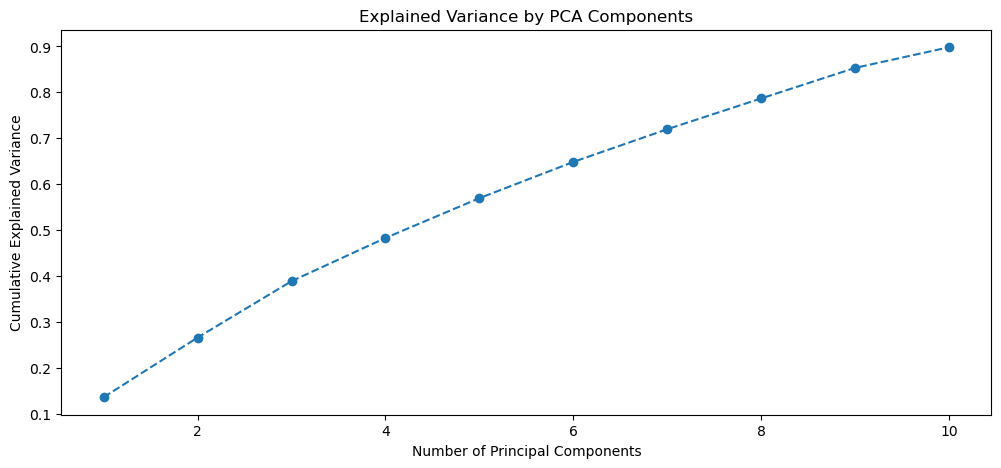

In [58]:
# plotting variance
plt.figure(figsize = (12, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.show()


In [59]:
explained_variance = pca.explained_variance_
total_explained_variance = explained_variance.sum()

print(explained_variance)
print(total_explained_variance)

[2.2182537  2.12929356 2.01142365 1.54123858 1.42041091 1.29282425
 1.16769012 1.0983394  1.08909517 0.73661643]
14.705185773608914


### Most variance cannot be explained by only a few components --> linearity (corr) of the training data check

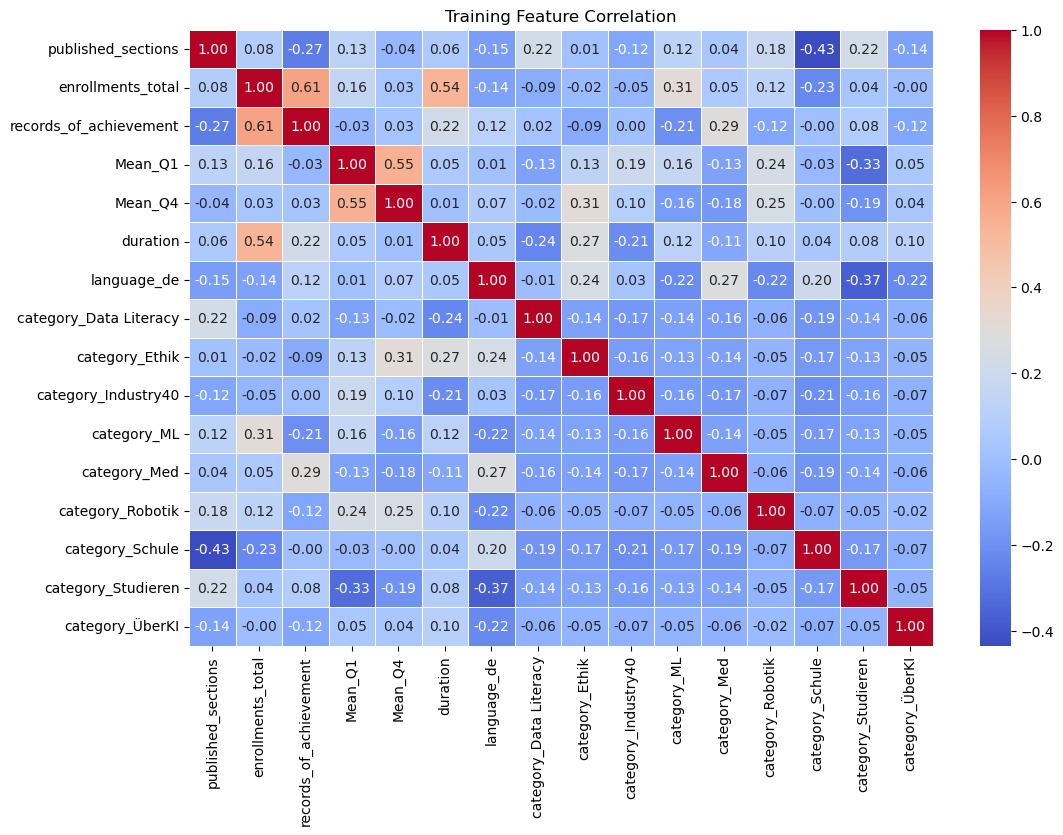

In [62]:
X_train_matrix = X_train.corr()

plt.figure(figsize = (12, 8))
sns.heatmap(X_train_matrix, annot = True, cmap = 'coolwarm', fmt = ".2f", linewidths = 0.5)
plt.title('Training Feature Correlation')
plt.show()

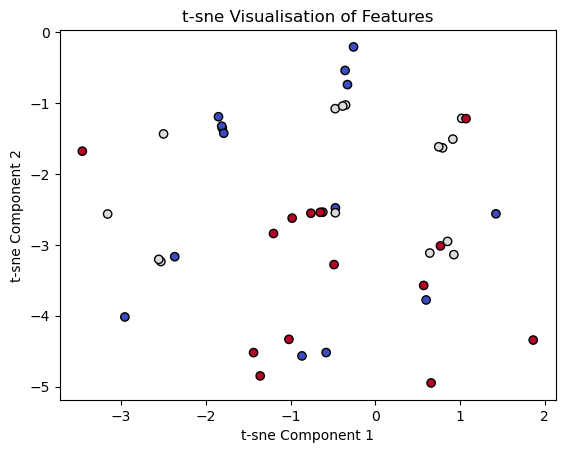

In [74]:
# The features do not have a linear relation ship. Check on t-SNE
tsne = TSNE(n_components = 2, random_state = 12, perplexity = 27, n_iter = 2500, learning_rate = 15)

X_train_tsne = tsne.fit_transform(X_train_scaled)

plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c = y_train, cmap = 'coolwarm', edgecolors = "k")
plt.xlabel('t-sne Component 1')
plt.ylabel('t-sne Component 2')
plt.title('t-sne Visualisation of Features')
plt.show()

## Data Augmentation with CTGAN

In [113]:
#! pip install ctgan
#! pip install sdv
from ctgan import CTGAN
from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer
from sdv.evaluation.single_table import evaluate_quality, get_column_plot

In [152]:
clean_training = training_df.drop(['title', 'Date go-live', 'Approx. date last enrolment', 'id', 'Sum_Q1', 'Sum_Q4'], axis = 1)
# ctgan does not accept pandas category datatype, need to convert back to str
categorical_cols = ['language', 'category', 'label']
clean_training[categorical_cols] = clean_training[categorical_cols].astype(str)

clean_X = clean_training.drop(['label'], axis = 1)
clean_y = clean_training['label']

X_train_sdv, X_temp_sdv, y_train_sdv, y_temp_sdv = train_test_split(clean_X, clean_y, test_size = 0.4, stratify = clean_y, random_state = 12)
X_val_sdv, X_test_sdv, y_val_sdv, y_test_sdv = train_test_split(X_temp_sdv, y_temp_sdv, test_size = 0.5, stratify = y_temp_sdv, random_state = 12)

train_data = X_train_sdv.copy()
train_data['label'] = y_train_sdv

In [154]:
print(train_data.head())

# metadata definition
metadata = Metadata.detect_from_dataframe(train_data)

print(metadata)

   language  published_sections  enrollments_total  records_of_achievement  \
55       de                   7                939                      50   
62       en                   8               2874                     344   
11       de                  18                689                      84   
14       de                   8                565                       0   
26       en                   7                191                      10   

      category   Mean_Q1   Mean_Q4  duration      label  
55          ML  3.545455  2.727273      1116     Update  
62   Studieren  3.186992  2.886179      1251  No update  
11         Med  3.193256  2.816321       655  No update  
14  Industry40  3.384615  3.076923       722     Update  
26      Schule  3.714286  2.857143       858     Update  
{
    "tables": {
        "table": {
            "columns": {
                "language": {
                    "sdtype": "categorical"
                },
                "published_s

In [155]:
ctgan = CTGANSynthesizer(metadata, epochs = 3000, verbose = True)
ctgan.fit(train_data)

C:\Users\ywa\AppData\Local\anaconda3\lib\site-packages\sdv\single_table\base.py:104: UserWarning:

We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.

Gen. (-0.66) | Discrim. (0.16): 100%|██████████████████████████████████████████████| 3000/3000 [04:28<00:00, 11.15it/s]


In [156]:
# sample 200 training samples
synthetic_data = ctgan.sample(num_rows = 200)
synthetic_data.head()

,language,published_sections,enrollments_total,records_of_achievement,category,Mean_Q1,Mean_Q4,duration,label
0,de,5,609,53,Schule,3.416998,3.078785,994,Update
1,en,7,382,34,Studieren,2.806243,2.300000,926,Archived
2,de,4,265,318,Schule,3.287924,2.916216,841,Update
3,de,12,1045,18,ÜberKI,3.361502,2.517140,1367,No update
4,en,13,1941,62,Med,3.557649,3.027000,916,Update


In [157]:
# Synthetic data evaluation
quality_report = evaluate_quality(real_data = train_data, synthetic_data = synthetic_data, metadata = metadata)
print(quality_report)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 820.00it/s]|
Column Shapes Score: 86.84%

(2/2) Evaluating Column Pair Trends: |███████████████████████████████████████████████| 36/36 [00:00<00:00, 131.10it/s]|
Column Pair Trends Score: 79.72%

Overall Score (Average): 83.28%



In [158]:
#visualise the evaluation for all features

# course language
get_column_plot(real_data = train_data, synthetic_data = synthetic_data, metadata = metadata, column_name = 'language')


C:\Users\ywa\AppData\Local\anaconda3\lib\site-packages\plotly\io\_renderers.py:55: UserWarning:

Plotly version >= 6 requires Jupyter Notebook >= 7 but you have 6.5.2 installed.
 To upgrade Jupyter Notebook, please run `pip install notebook --upgrade`.



In [159]:

# number of modules
get_column_plot(real_data = train_data, synthetic_data = synthetic_data, metadata = metadata, column_name = 'published_sections')


C:\Users\ywa\AppData\Local\anaconda3\lib\site-packages\plotly\io\_renderers.py:55: UserWarning:

Plotly version >= 6 requires Jupyter Notebook >= 7 but you have 6.5.2 installed.
 To upgrade Jupyter Notebook, please run `pip install notebook --upgrade`.



In [160]:

# total enrolment
get_column_plot(real_data = train_data, synthetic_data = synthetic_data, metadata = metadata, column_name = 'enrollments_total')


C:\Users\ywa\AppData\Local\anaconda3\lib\site-packages\plotly\io\_renderers.py:55: UserWarning:

Plotly version >= 6 requires Jupyter Notebook >= 7 but you have 6.5.2 installed.
 To upgrade Jupyter Notebook, please run `pip install notebook --upgrade`.



In [161]:

# total RoA
get_column_plot(real_data = train_data, synthetic_data = synthetic_data, metadata = metadata, column_name = 'records_of_achievement')


C:\Users\ywa\AppData\Local\anaconda3\lib\site-packages\plotly\io\_renderers.py:55: UserWarning:

Plotly version >= 6 requires Jupyter Notebook >= 7 but you have 6.5.2 installed.
 To upgrade Jupyter Notebook, please run `pip install notebook --upgrade`.



In [162]:

# course category
get_column_plot(real_data = train_data, synthetic_data = synthetic_data, metadata = metadata, column_name = 'category')


C:\Users\ywa\AppData\Local\anaconda3\lib\site-packages\plotly\io\_renderers.py:55: UserWarning:

Plotly version >= 6 requires Jupyter Notebook >= 7 but you have 6.5.2 installed.
 To upgrade Jupyter Notebook, please run `pip install notebook --upgrade`.



In [163]:

# Mean_Q1
get_column_plot(real_data = train_data, synthetic_data = synthetic_data, metadata = metadata, column_name = 'Mean_Q1')


C:\Users\ywa\AppData\Local\anaconda3\lib\site-packages\plotly\io\_renderers.py:55: UserWarning:

Plotly version >= 6 requires Jupyter Notebook >= 7 but you have 6.5.2 installed.
 To upgrade Jupyter Notebook, please run `pip install notebook --upgrade`.



In [164]:

# Mean_Q4
get_column_plot(real_data = train_data, synthetic_data = synthetic_data, metadata = metadata, column_name = 'Mean_Q4')


C:\Users\ywa\AppData\Local\anaconda3\lib\site-packages\plotly\io\_renderers.py:55: UserWarning:

Plotly version >= 6 requires Jupyter Notebook >= 7 but you have 6.5.2 installed.
 To upgrade Jupyter Notebook, please run `pip install notebook --upgrade`.



In [165]:

# Course live duration 
get_column_plot(real_data = train_data, synthetic_data = synthetic_data, metadata = metadata, column_name = 'duration')


C:\Users\ywa\AppData\Local\anaconda3\lib\site-packages\plotly\io\_renderers.py:55: UserWarning:

Plotly version >= 6 requires Jupyter Notebook >= 7 but you have 6.5.2 installed.
 To upgrade Jupyter Notebook, please run `pip install notebook --upgrade`.



In [167]:

# target var
get_column_plot(real_data = train_data, synthetic_data = synthetic_data, metadata = metadata, column_name = 'label')


C:\Users\ywa\AppData\Local\anaconda3\lib\site-packages\plotly\io\_renderers.py:55: UserWarning:

Plotly version >= 6 requires Jupyter Notebook >= 7 but you have 6.5.2 installed.
 To upgrade Jupyter Notebook, please run `pip install notebook --upgrade`.



In [168]:
X_synthetic_train = synthetic_data.drop(['label'], axis = 1)
y_synthetic_train = synthetic_data['label']

print(X_synthetic_train.shape)
print(y_synthetic_train.shape)

(200, 8)
(200,)


In [172]:
print(X_train_sdv.shape)
print(y_train_sdv.shape)

X_train_augmented = pd.concat([X_train_sdv, X_synthetic_train])
y_train_augmented = pd.concat([y_train_sdv, y_synthetic_train])

print(X_train_augmented.shape)
print(y_train_augmented.shape)

(44, 8)
(44,)
(244, 8)
(244,)


In [ ]:
# retrain model with grid search



In [ ]:
# model evaluation